In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement, combinations, permutations, product

In [4]:
#Compute input size that leads to a 1x1 output size, among other things   

# [filter size, stride, padding]
vgg19 =[[3,1,1],[3,1,1], [2,2,0], [3,1,1], [3,1,1], [2,2,0], [3,1,1], [3,1,1],[2,2,0],\
          [3,1,1], [3,1,1], [3,1,1], [3,1,1],[2,2,0], [3,1,1], [3,1,1], [3,1,1], [3,1,1], [2,2,0]]
layer_names = ['conv1_1', 'conv1_2','pool1','conv2_1', 'conv2_2', 'pool2', 'conv3_1', \
              'conv3_2','pool3','conv4_1','conv4_2','conv4_3','conv4_4','pool4',\
              'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4', 'pool5']
imsize = 256

def get_net_size(insize, net = vgg19):
    out_size = np.zeros(len(net))
    rf_size = np.zeros(len(net))
    tot_stride = np.zeros(len(net))
    start1 = np.zeros(len(net), dtype=np.float64)
    
    totstride = 1
    startPos = 0.5
    rf_sz = net[0][0]
    for layer in range(len(net)):
        filt_sz, stride, pad = net[layer]
        
        # Calculate outsize as a function of insize
        out_sz = np.floor((insize - filt_sz + 2*pad) / stride) + 1

        actualP = (out_sz-1)*stride - insize + filt_sz
        pL = np.floor(actualP/2)

        # Calculate RF size as a function of previous layer RF size
        if layer > 0:
            rf_sz = rf_sz + (filt_sz-1)*totstride
            
        # Start position
        startPos = startPos + ((filt_sz-1)/2.0 - pL)*totstride
        
        # Distance between the center of adjacent features 
        totstride = totstride * stride
        
        out_size[layer], rf_size[layer], tot_stride[layer] = out_sz, rf_sz, totstride
        start1[layer] = startPos
        
        insize = out_sz
        
    net_size = {'out_size': out_size, 'rf_size': rf_size, 'tot_stride': tot_stride, 'center00': start1}
    return net_size

def print_layer_sizes():
    net_size = get_net_size(imsize)
    out_size,rf_size,tot_stride,center00 = net_size['out_size'], net_size['rf_size'],\
                                        net_size['tot_stride'], net_size['center00']
    print "layer output sizes given image = %dx%d\n" % (imsize, imsize)
    for i in range(len(vgg19)):
        print "%7s: \tOutput size = %3d\t RF Size = %3d\t  Jump = %3d\t Center00 = %3g" \
                % (layer_names[i], out_size[i], rf_size[i], tot_stride[i], center00[i])
print_layer_sizes() 

layer output sizes given image = 256x256

conv1_1: 	Output size = 256	 RF Size =   3	  Jump =   1	 Center00 = 0.5
conv1_2: 	Output size = 256	 RF Size =   5	  Jump =   1	 Center00 = 0.5
  pool1: 	Output size = 128	 RF Size =   6	  Jump =   2	 Center00 =   1
conv2_1: 	Output size = 128	 RF Size =  10	  Jump =   2	 Center00 =   1
conv2_2: 	Output size = 128	 RF Size =  14	  Jump =   2	 Center00 =   1
  pool2: 	Output size =  64	 RF Size =  16	  Jump =   4	 Center00 =   2
conv3_1: 	Output size =  64	 RF Size =  24	  Jump =   4	 Center00 =   2
conv3_2: 	Output size =  64	 RF Size =  32	  Jump =   4	 Center00 =   2
  pool3: 	Output size =  32	 RF Size =  36	  Jump =   8	 Center00 =   4
conv4_1: 	Output size =  32	 RF Size =  52	  Jump =   8	 Center00 =   4
conv4_2: 	Output size =  32	 RF Size =  68	  Jump =   8	 Center00 =   4
conv4_3: 	Output size =  32	 RF Size =  84	  Jump =   8	 Center00 =   4
conv4_4: 	Output size =  32	 RF Size = 100	  Jump =   8	 Center00 =   4
  pool4: 	Output size 

In [60]:
import time
def get_rf_coords(layerName, pos, layernames=layer_names, imsize=256):
    net_size = get_net_size(imsize)
    
    lay_idx = layernames.index(layerName)
    
    out_size = net_size['out_size'][lay_idx]
    
    assert(pos[0] < out_size)
    assert(pos[1] < out_size)
    
    rf_size = net_size['rf_size'][lay_idx]
    start = net_size['center00'][lay_idx]

    jump = net_size['tot_stride'][lay_idx]
    center = [start+pos[0]*jump, start + pos[1]*jump]
    
    top_left = [center[0] - rf_size/2.0, center[1] - rf_size/2.0]
    bottom_right = [center[0] + rf_size/2.0, center[1] + rf_size/2.0]

    return rf_size, center, [top_left, bottom_right]

def draw_rf(layer, pos, imsize=256):
    rf_sz, center, extent = get_rf_coords(lname, pos, imsize=imsize)
    top_left, bottom_right = extent
    #print 'Layer %s, Index (%d, %d) has receptive field size %d centered at position (%g, %g)' \
    #    % (lname, pos[0], pos[1], rf_sz, center[0], center[1])
    #print 'RF goes from [%g, %g] to [%g, %g]' % (top_left[0], top_left[1], bottom_right[0], bottom_right[1])

    im = np.zeros((imsize, imsize))
    tl, br = extent
    for xi in range(imsize):
        for yi in range(imsize):
            if xi >= tl[0] and xi <= br[0] and yi >= tl[1] and yi <= br[1]:
                im[xi,yi] = 1
    return im



[2.0, 2.0] [18.0, 18.0]


In [66]:
def precompute_layer_subset_weights(self, imsize=256):
    layer_names = ['conv1_1', 'conv1_2','pool1','conv2_1', 'conv2_2', 'pool2', 'conv3_1', \
              'conv3_2','pool3','conv4_1','conv4_2','conv4_3','conv4_4','pool4',\
              'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4', 'pool5']

    lsub_weights = {}
    for layI in range(len(layer_names)):
        lname = layer_names[layI]
        out_size = self.net_size['out_size'][layI]
        rf_size = self.net_size['rf_size'][layI]
        start = self.net_size['center00'][layI]
        jump = self.net_size['tot_stride'][layI]
        
        nSubsets = len(self.subset_boundaries)
        layer_weight = np.zeros((out_size, out_size, nSubsets))

        for si in range(nSubsets):
            isub = self.subset_boundaries[si]
            for xi in range(out_size):
                for yi in range(out_size):
                    pos = [xi,yi]
                    rf_size, center, [tl,br] = get_rf_coords(lname, pos)
                    layer_weights[xi,yi,si] = calc_overlap([tl,br], isub)

        lsub_weights[lname] = layer_weight

    return lsub_weights

def calc_proportion_overlap(rf, subset):
    print 'RF: ', rf, 'Subset: ', subset
    
    # Calculate what percentage of the receptive field is contained within the subset
    tl_subset, br_subset = subset[0], subset[1] # rect1
    tl_rf, br_rf = rf[0], rf[1] # rect2
    
    rf_area = (br_rf[0] - tl_rf[0])*(br_rf[1] - tl_rf[1])
    print 'rf_area', rf_area
    
    x_overlap = np.maximum(0, np.minimum(br_subset[0], br_rf[0]) - np.maximum(tl_subset[0], tl_rf[0]));
    y_overlap = np.maximum(0, np.minimum(br_subset[1], br_rf[1]) - np.maximum(tl_subset[1], tl_rf[1]));
    print 'overlap: ', x_overlap, y_overlap
    overlapArea = 1.0*x_overlap * y_overlap / rf_area;
    
    # calculate percentage of receptive field that overlaps
    return overlapArea

rf_size, center, [tl,br] = get_rf_coords('pool2', [2, 2])
subset = [[0, 0], [128, 128]]
overlap = calc_overlap(subset, [tl, br])
print 'overlap: ', overlap

RF:  [[0, 0], [128, 128]] Subset:  [[2.0, 2.0], [18.0, 18.0]]
rf_area 16384
overlap:  16.0 16.0
overlap:  0.015625


TypeError: colorbar() takes at least 2 arguments (1 given)

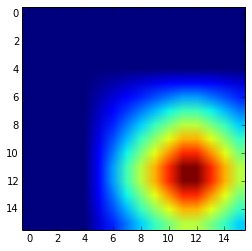

In [73]:
a = np.load('tmp/p4.npy')
a.shape
fig = plt.figure()
plt.imshow(a[:,:,3])
fig.colorbar()

In [8]:
def get_rf_coords(self, layerName, pos, imsize=256):
    layer_names = ['conv1_1', 'conv1_2','pool1','conv2_1', 'conv2_2', 'pool2', 'conv3_1', \
              'conv3_2','pool3','conv4_1','conv4_2','conv4_3','conv4_4','pool4',\
              'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4', 'pool5']

    lay_idx = layer_names.index(layerName)
    
    out_size = self.net_size['out_size'][lay_idx]
    
    assert(pos[0] < out_size)
    assert(pos[1] < out_size)
    
    rf_size = self.net_size['rf_size'][lay_idx]
    start = self.net_size['center00'][lay_idx]

    jump = self.net_size['tot_stride'][lay_idx]
    center = [start+pos[0,:]*jump, start + pos[1,:]*jump]
    
    top_left = [center[0] - rf_size/2.0, center[1] - rf_size/2.0]
    bottom_right = [center[0] + rf_size/2.0, center[1] + rf_size/2.0]

    return rf_size, center, [top_left, bottom_right]

get_rf_coords([], 'pool4', [4, 1])

AttributeError: 'list' object has no attribute 'net_size'

In [ ]:
def get_rf_overlap(layerName, rf, layernames=layer_names, imsize=256):
    # we want to return a matrix of the same size as the output of the layer.
    net_size = get_net_size(imsize)
    
    lay_idx = layernames.index(layerName)
    
    out_size = net_size['out_size'][lay_idx]
    
    wm = np.zeros((out_size, out_size))
    rf_size, center, [tl,br] = get_rf_coords
    
    rf_size = net_size['rf_size'][lay_idx]
    start = net_size['center00'][lay_idx]

    jump = net_size['tot_stride'][lay_idx]
    center = [start+pos[0]*jump, start + pos[1]*jump]
    
    top_left = [center[0] - rf_size/2.0, center[1] - rf_size/2.0]
    bottom_right = [center[0] + rf_size/2.0, center[1] + rf_size/2.0]

    return rf_size, center, [top_left, bottom_right]


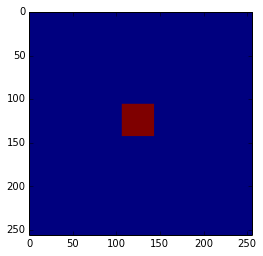

In [6]:
## Define layer name and position
lname = 'pool3'
pos = [15, 15] 

im = draw_rf(lname, pos)
plt.imshow(im)

In [78]:

# [filter size, stride, padding]
#Assume the two dimensions are the same
#Each kernel requires the following parameters:
# - k_i: kernel size
# - s_i: stride
# - p_i: padding (if padding is uneven, right padding will higher than left padding; "SAME" option in tensorflow)
# 
#Each layer i requires the following parameters to be fully represented: 
# - n_i: number of feature (data layer has n_1 = imagesize )
# - j_i: distance (projected to image pixel distance) between center of two adjacent features
# - r_i: receptive field of a feature in layer i
# - start_i: position of the first feature's receptive field in layer i (idx start from 0, negative means the center fall into padding)

import math

convnet =[[3,1,1],[3,1,1], [2,2,0], [3,1,1], [3,1,1], [2,2,0], [3,1,1], [3,1,1],[2,2,0],\
          [3,1,1], [3,1,1], [3,1,1], [3,1,1],[2,2,0], [3,1,1], [3,1,1], [3,1,1], [3,1,1], [2,2,0]]
layer_names = ['conv1_1', 'conv1_2','pool1','conv2_1', 'conv2_2', 'pool2', 'conv3_1', \
              'conv3_2','pool3','conv4_1','conv4_2','conv4_3','conv4_4','pool4',\
              'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4', 'pool5']
imsize = 256


def outFromIn(conv, layerIn):
    n_in = layerIn[0]
    j_in = layerIn[1]
    r_in = layerIn[2]
    start_in = layerIn[3]
    k = conv[0]
    s = conv[1]
    p = conv[2]

    n_out = math.floor((n_in - k + 2*p)/s) + 1
    actualP = (n_out-1)*s - n_in + k 
    pR = math.ceil(actualP/2)
    pL = math.floor(actualP/2)

    j_out = j_in * s
    r_out = r_in + (k - 1)*j_in
    start_out = start_in + ((k-1)/2 - pL)*j_in
    return n_out, j_out, r_out, start_out
  
layerInfos = []
#first layer is the data layer (image) with n_0 = image size; j_0 = 1; r_0 = 1; and start_0 = 0.5
currentLayer = [imsize, 1, 1, 0.5]
for i in range(len(convnet)):
    currentLayer = outFromIn(convnet[i], currentLayer)
    layerInfos.append(currentLayer)
layer_name = raw_input ("Layer name where the feature in: ")
layer_idx = layer_names.index(layer_name)
idx_x = int(raw_input ("index of the feature in x dimension (from 0)"))
idx_y = int(raw_input ("index of the feature in y dimension (from 0)"))

n = layerInfos[layer_idx][0]
j = layerInfos[layer_idx][1]
r = layerInfos[layer_idx][2]
start = layerInfos[layer_idx][3]
assert(idx_x < n)
assert(idx_y < n)

print ("receptive field: (%s, %s)" % (r, r))
print ("center: (%s, %s)" % (start+idx_x*j, start+idx_y*j))

Layer name where the feature in: pool3
index of the feature in x dimension (from 0)1
index of the feature in y dimension (from 0)1
receptive field: (36, 36)
center: (8.5, 8.5)
